<b>Data Source: MetaTrader 5 </b>

In this analysis, I applied a Triple Exponential Smoothing (Holt-Winters) model to forecast daily USD/JPY exchange rates, leveraging historical forex data sourced from MetaTrader 5. The dataset included daily observations of the currency pair's open, high, low, and close prices. After thorough data preprocessing—setting a consistent daily frequency, handling missing values, and renaming variables—I conducted exploratory analysis through visualizations of time series plots, monthly and quarterly seasonality assessments, and decomposition to uncover trend and seasonal patterns. I further analyzed autocorrelation and partial autocorrelation structures using ACF and PACF plots to understand underlying dependencies. The time series was split into training and testing sets, with the model trained on the earlier portion and validated on the latter. Using an additive trend and seasonality specification with a seasonal period of 365 days, the Holt-Winters model produced forecasts that were evaluated via MAE, RMSE, and MAPE metrics. The final visualization illustrated the alignment of forecasted values with actual observations, providing insight into the model’s practical forecasting performance for forex trading applications.

# Importing Library

In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.ticker import MultipleLocator
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [4]:
# Set the index when we import the data
df = pd.read_csv("DAILY_USDJPY.csv", index_col = "DATE", parse_dates=True)
df

,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
DATE,,,,,,,
1971-01-04,357.730,357.730,357.730,357.730,1,0,50
1971-01-05,357.810,357.810,357.810,357.810,1,0,50
1971-01-06,357.860,357.860,357.860,357.860,1,0,50
1971-01-07,357.870,357.870,357.870,357.870,1,0,50
1971-01-08,357.820,357.820,357.820,357.820,1,0,50
...,...,...,...,...,...,...,...
2025-04-28,143.610,143.885,141.926,141.927,98567,0,4
2025-04-29,141.954,142.748,141.954,142.254,95470,0,13
2025-04-30,142.228,143.180,142.136,143.027,99923,0,0


In [5]:
df = df.rename(columns = {"CLOSE": "y"})
df.head()

,OPEN,HIGH,LOW,y,TICKVOL,VOL,SPREAD
DATE,,,,,,,
1971-01-04,357.73,357.73,357.73,357.73,1,0,50
1971-01-05,357.81,357.81,357.81,357.81,1,0,50
1971-01-06,357.86,357.86,357.86,357.86,1,0,50
1971-01-07,357.87,357.87,357.87,357.87,1,0,50
1971-01-08,357.82,357.82,357.82,357.82,1,0,50


In [6]:
# Change the frequency
df = df.asfreq('D')
df.index

DatetimeIndex(['1971-01-04', '1971-01-05', '1971-01-06', '1971-01-07',
               '1971-01-08', '1971-01-09', '1971-01-10', '1971-01-11',
               '1971-01-12', '1971-01-13',
               ...
               '2025-04-23', '2025-04-24', '2025-04-25', '2025-04-26',
               '2025-04-27', '2025-04-28', '2025-04-29', '2025-04-30',
               '2025-05-01', '2025-05-02'],
              dtype='datetime64[ns]', name='DATE', length=19843, freq='D')

In [7]:
df = df.dropna(subset=['OPEN', 'HIGH', 'LOW', 'y'])
df.isnull().sum()

OPEN       0
HIGH       0
LOW        0
y          0
TICKVOL    0
VOL        0
SPREAD     0
dtype: int64

# Data Visualization

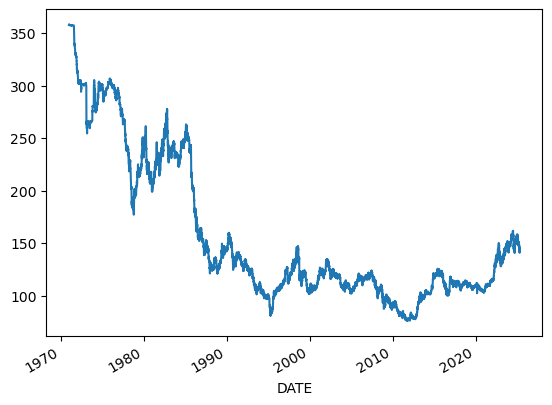

In [9]:
# Daily Closing Price Plot
df["y"].plot()
plt.show()

The plot displayed represents the historical daily closing prices of the USD/JPY currency pair over a period spanning from approximately 1970 to the early 2020s. The graph reveals significant long-term fluctuations, including a pronounced decline from the 1970s through the mid-1990s, followed by relatively stable movements with periodic oscillations in the subsequent decades. Notably, an upward trend is observable beginning around 2012, reflecting a gradual strengthening of the U.S. dollar against the Japanese yen in recent years. This visualization provides an essential initial insight into the overall trend and volatility characteristics of the forex time series prior to model development.

# Seasonality

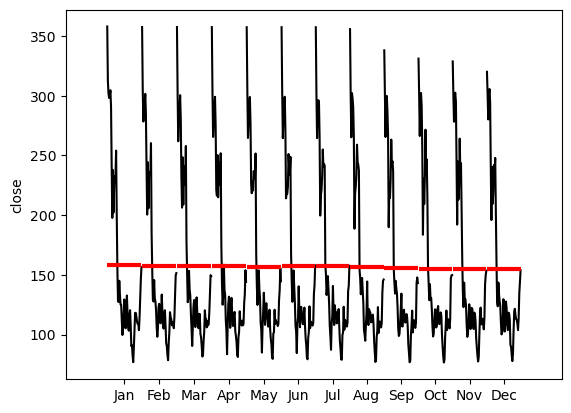

In [11]:
#montly seasonality
month_plot(df["y"].resample("ME").mean(),
          ylabel='close')
plt.show()

* The highest average exchange rates tend to appear in the early months of the year (around January to March), suggesting that the USD/JPY pair typically strengthens during this period.

* This is followed by a gradual decline from mid-year onward, with the lowest values often occurring between August and October.

* A moderate rebound is observed toward the end of the year, particularly in December.

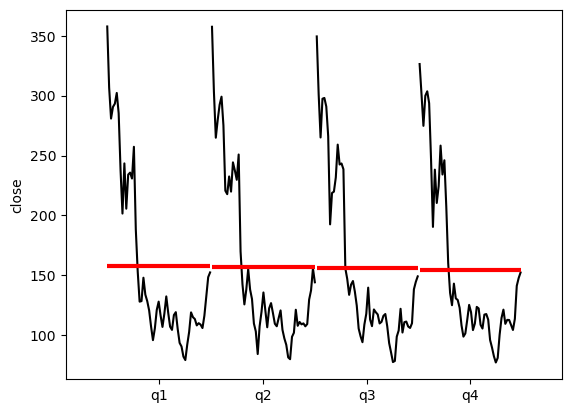

In [12]:
#quarter plot
quarter_plot(df["y"].resample("QE").mean(),
          ylabel='close')
plt.show()

This quarterly view reinforces the monthly seasonality findings, emphasizing a recurrent annual cycle where the USD/JPY pair tends to be strongest at the start of the year and weakest through midyear, with partial stabilization toward year-end. 

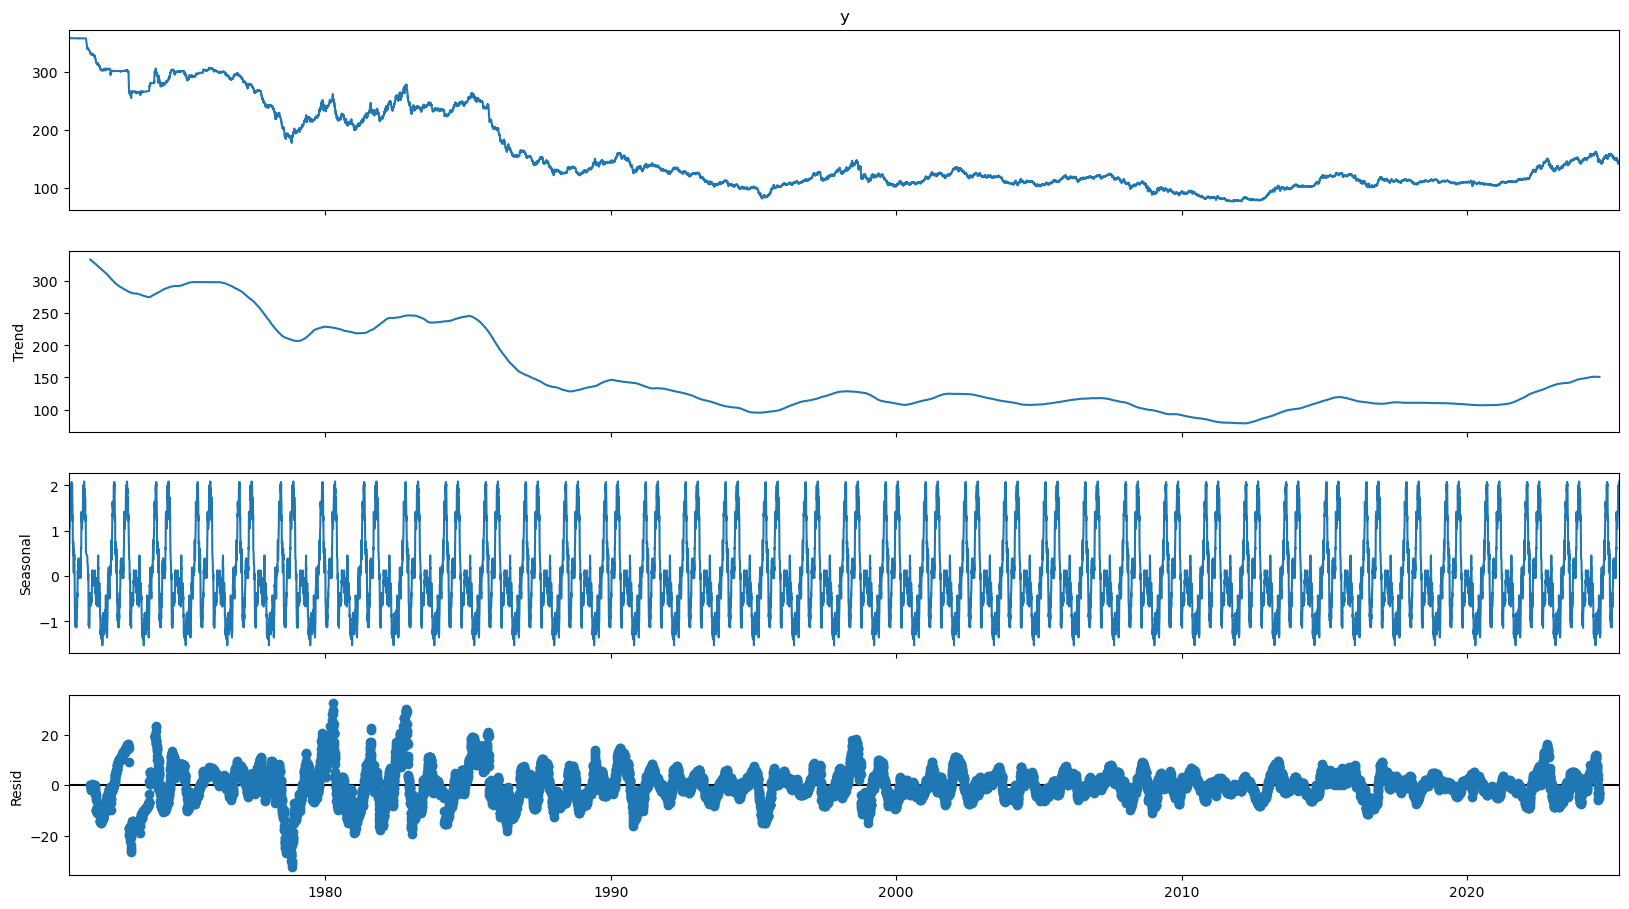

In [47]:
# Seasonal decomposition for df['Adj. Close']
decomposition = seasonal_decompose(df['y'],
                                  model = 'additive',
                                  period = 365)
fig = decomposition.plot()
fig.set_size_inches(18, 10)
plt.show()

* The additive model was selected because the size of seasonal effects remained constant over time, and a 365-day period was chosen based on both domain knowledge and visual evidence of strong annual seasonality, ensuring that the decomposition captures the true underlying patterns in the data effectively.
* The decomposition reveals that the USD/JPY exchange rate is driven by a clear long-term downward trend from the 1970s to around 2012, followed by a moderate recovery in recent years. The annual seasonality component shows consistent, repeating cycles each year, indicating predictable seasonal behavior likely tied to economic and fiscal events. After accounting for trend and seasonality, the residuals appear random, suggesting that the model effectively captures the main systematic patterns in the data.

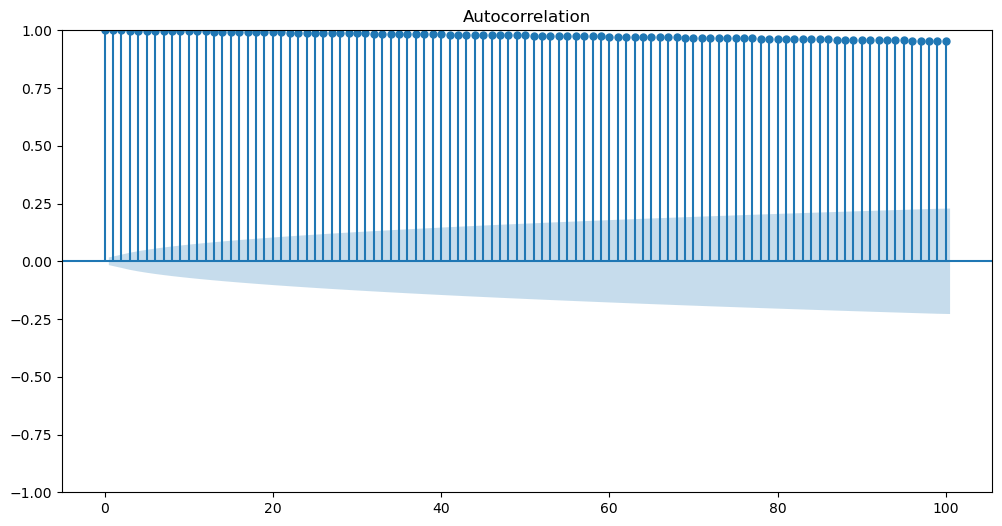

In [14]:
# Plot the ACF of the
fig, ax = plt.subplots(figsize = (12, 6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

This ACF plot confirms that the data has strong autocorrelation and non-stationary behavior, highlighting the importance of accounting for long-term dependencies when modeling or forecasting.

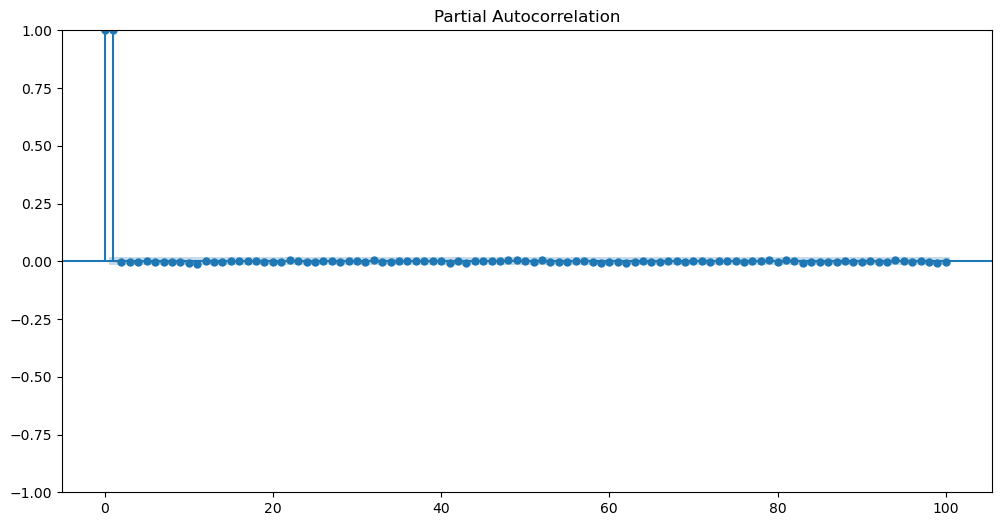

In [15]:
# PACF
fig, ax = plt.subplots(figsize = (12, 6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

This PACF plot indicates that the time series is primarily influenced by its immediate past two observations, with minimal direct influence from longer lags, highlighting the importance of lag 1 and lag 2 in this data.

# Training and Test

In [17]:
#spliting data into training and test
period = 2800
train = df.iloc[:-period].y
test = df.iloc[-period:].y
train

DATE
1971-01-04    357.730
1971-01-05    357.810
1971-01-06    357.860
1971-01-07    357.870
1971-01-08    357.820
               ...   
2014-07-16    101.656
2014-07-17    101.149
2014-07-18    101.343
2014-07-21    101.404
2014-07-22    101.465
Name: y, Length: 11211, dtype: float64

This step prepares the data by separating historical data (for model training) from a recent segment (for testing the model’s forecast accuracy), ensuring that the model is evaluated on unseen data to mimic real-world forecasting. The initial dataset contains approximately 14,011 records, and by setting period = 2800, the split results in roughly 80% of the data used for training (around 11,200 observations) and 20% for testing, following a common and balanced practice in time series modeling to ensure sufficient data for both model fitting and evaluation.

# Triple Exponential Smoothing

In [19]:
# Build the holt-winters model
model_triple = ExponentialSmoothing(
    endog = train,
    trend='add',
    seasonal='add',
    seasonal_periods=365).fit()
print(model_triple.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                11211
Model:             ExponentialSmoothing   SSE                          11987.728
Optimized:                         True   AIC                           1489.002
Trend:                         Additive   BIC                           4191.798
Seasonal:                      Additive   AICC                          1514.468
Seasonal Periods:                   365   Date:                 Mon, 05 May 2025
Box-Cox:                          False   Time:                         16:07:49
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9962222                alpha                 True
smoothing_trend       

 result confirms that:
* The model captures a long-term trend and yearly seasonality,
* The seasonal component is very stable (small gamma), which aligns with the earlier decomposition findings,
* The model was fit successfully and is ready to forecast the test set.

In [20]:
# Predict with the holt-winters model
triple_pred = pd.Series(model_triple.forecast(len(test)).values, index=test.index)
triple_pred

DATE
2014-07-23    101.337987
2014-07-24    101.420948
2014-07-25    101.333137
2014-07-28    101.190444
2014-07-29    101.212415
                 ...    
2025-04-28    177.165399
2025-04-29    177.212819
2025-04-30    177.200939
2025-05-01    177.121513
2025-05-02    176.914665
Length: 2800, dtype: float64

# Evaluate

In [22]:
#calculate and print the MAE, RMSE, MAPE
mae = mean_absolute_error(test, triple_pred)
rmse = root_mean_squared_error(test, triple_pred)
mape = mean_absolute_percentage_error(test, triple_pred)

#simple exponential smoothing
print('Simple Exponential Smoothing')
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', 100 * mape)

Simple Exponential Smoothing
MAE: 20.562041898302684
RMSE: 23.40088870688547
MAPE: 17.60494533448816


* MAE (Mean Absolute Error):
Measures the average size of the errors between the forecast and the actual values, without considering their direction.
* RMSE (Root Mean Squared Error):
Gives a higher weight to large errors by squaring the differences before averaging. It’s sensitive to outliers.
* MAPE (Mean Absolute Percentage Error):
Expresses the error as a percentage of the actual values, making it easier to interpret across different scales.

MAE (~20.56):
On average, the model’s forecast misses the true exchange rate by about 20.56 units.

RMSE (~23.40):
Larger errors have a bit more impact here, and the typical error magnitude (accounting for bigger misses) is about 23.40 units.

MAPE (~17.6%):
On average, the forecast error is about 17.6% of the actual exchange rate value, which gives a sense of relative accuracy.

This evaluation step quantifies the model’s performance on unseen data, showing that while the model generally tracks the data closely (errors are moderate), the MAPE indicates the forecast may vary around ±17% from the actual values—a useful benchmark for assessing forecast reliability.

# Model Assessment

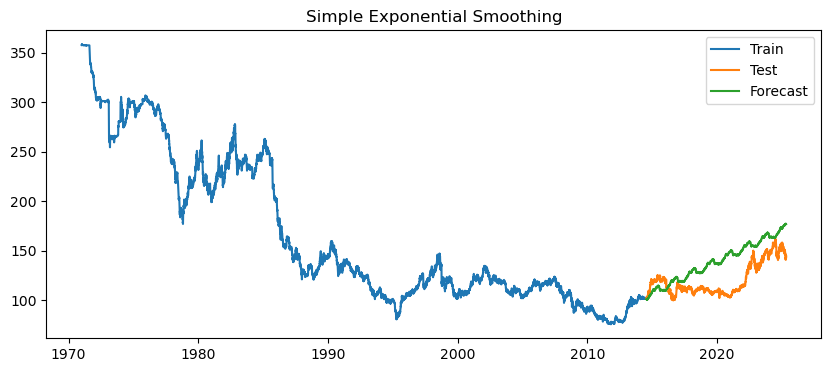

RMSE: 23
MAE: 21
MAPE: 17.6 %


In [24]:
# Function that assesses the model and visualizes the train, test and forecast
def model_assessment(train, test, predictions, chart_title = None):
  # Set the chart size
  plt.figure(figsize = (10, 4))

  # Plot the train, test and forecast
  plt.plot(train, label = "Train")
  plt.plot(test, label = "Test")
  plt.plot(predictions, label = "Forecast")
  plt.title(chart_title)
  plt.legend()
  plt.show()

  # Calculate and print the RMSE, MAE, and MAPE
  rmse = root_mean_squared_error(test, predictions)
  mae = mean_absolute_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)
  print(f"RMSE: {rmse:.0f}")
  print(f"MAE: {mae:.0f}")
  print(f"MAPE: {100 * mape:.1f} %")
#apply the function
model_assessment(train, test, triple_pred, "Simple Exponential Smoothing")

# Conclution
While the Holt-Winters model captures the long-term trend and seasonality structure, its forecasts diverge noticeably from the actual test data, particularly in the later periods. This indicates that the model, although useful for understanding overall patterns, lacks precision for accurate long-term forecasting in a volatile financial context like forex. To improve performance, exploring more advanced models (such as ARIMA, SARIMA, or machine learning-based methods) or refining parameter tuning may be necessary.